# Part two

## Preparation

In [2]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('t8.shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 5458199


To make inputs out of this big string of data, we will be splitting it into chunks.

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

 most filthy bargain.
  OTHELLO. Ha!
  EMILIA. Do thy worst;
    This deed of thine is no more worthy heaven
    Than thou wast worthy her.
  OTHELLO.                     Peace, you were best.
  EMILIA


## Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [7]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [59]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    probs = []

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        norm_dist = output_dist/torch.sum(output_dist)
        prob, top_i = norm_dist.max(0)
#         top_i = torch.multinomial(norm_dist, 1)[0]
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
#         probs.append(norm_dist[top_i].item())
        probs.append(prob)
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    probs = torch.FloatTensor(probs)

    perplexity = (-1 * torch.sum(torch.log(probs))/predict_len)
    return predicted,perplexity.item()

## Training

A helper to print the amount of time passed:

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [16]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [44]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 13s (100 5%) 2.2658]
('Wher yound ou thetereag; theimerat the avon the surartt the  the mat hat hou then.                   p', tensor(0.2369)) 

 26s (200 10%) 1.9666]
("Whtot hat gropre wat dotid and the sot-we'd,\n                       O I heis!\n       To, sin!\n        ", tensor(0.2443)) 

 40s (300 15%) 2.1108]
('Whous;    loth youre meess moningeslls,\n          Hack prid ir now sicest you wake sous. And an this. ', tensor(0.1813)) 

 53s (400 20%) 2.1400]
("Whing\n  And I Gath, thees wheas thinge erp'd's his age and and hall bamarn!\n              Whath him la", tensor(0.2277)) 

 6s (500 25%) 2.1555]
('Whe reptret it.\n  DEBMION. The she stall be for coum blant.\n   AJIBONTIBUS DISAR MARSSIO UF ANDwE\n   M', tensor(0.1575)) 

 22s (600 30%) 1.5951]
('Whe there well\n   The of him west the me mut. \n   Pulef ands to must up here mowe uthin the knill ours', tensor(0.2147)) 

 37s (700 35%) 1.8401]
('Whe srife?\n              He charonester-\n                  Ence that dist fr

## Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

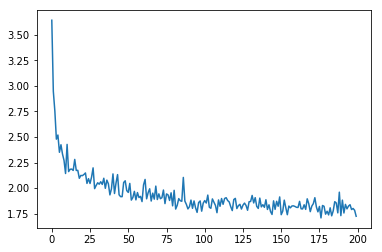

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [58]:
print(evaluate('Th', 5, temperature=0.8))

tensor(14)
tensor(14)
tensor(94)
tensor(94)
tensor(22)
tensor(29)
tensor(17)
tensor(17)
tensor(14)
tensor(14)
[tensor(0.7939), tensor(0.8489), tensor(0.1452), tensor(0.8286), tensor(0.8320)]
('The the', tensor(0.5392))


Lower temperatures are less varied, choosing only the more probable outputs:

In [60]:
print(evaluate('Th', 200, temperature=0.2))

('The me the shall the shall the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see', 0.2181037962436676)


Higher temperatures more varied, choosing less probable outputs:

In [64]:
print(evaluate('Th', 300, temperature=0.4))

('The me the shall the shall the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the see the', 0.4449905455112457)
